In [1]:
import numpy as np
from einops import rearrange

from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity

import os

In [2]:
 # HARDCODED FOR LLAVA
num_heads_llm = 40
num_layers_llm = 40

In [5]:
base_dir = 'vgr_probing/features_truthful/train'
val_ratio = 0.2
n_samples = 500

In [6]:
head_truth_llm = np.load(f"{base_dir}/truth/head_wise_{n_samples}_llm.npy")
print('llm', head_truth_llm.shape)
head_truth_llm = rearrange(head_truth_llm, 'b l (h d) -> b l h d', h = num_heads_llm)
print('llm reshape', head_truth_llm.shape)
head_non_truth_llm = np.load(f"{base_dir}/non_truth/head_wise_{n_samples}_llm.npy")
head_non_truth_llm = rearrange(head_non_truth_llm, 'b l (h d) -> b l h d', h = num_heads_llm)

labels_truth = np.load(f"{base_dir}/truth/labels_{n_samples}.npy")
labels_non_truth = np.load(f"{base_dir}/non_truth/labels_{n_samples}.npy")

llm (500, 40, 5120)
llm reshape (500, 40, 40, 128)


## Lets analyze the accuracy

In [7]:
X_all_llm = np.vstack((head_truth_llm, head_non_truth_llm))
y_all = np.hstack((labels_truth, labels_non_truth))

In [8]:
def get_performance_dict(X, y, num_layers, num_heads):
    head_perf_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)}
    for l in tqdm(range(num_layers)):
        for h in range(num_heads):
            X_probe = X[:, l, h, :]
            y_probe = y[:]
            _, val_acc = train_single_prob(X_probe, y_probe, val_size=val_ratio)
            head_perf_dict[f'l{l}_h{h}'] = val_acc
    return head_perf_dict

In [9]:
def get_perf_array(X_all, y_all, num_layers, num_heads):
    head_perf_dict = get_performance_dict(X_all, y_all, num_layers, num_heads)
    l_h_means = np.array(list(head_perf_dict.values())).reshape(num_layers, num_heads) # row = heads | colums = layers
    return l_h_means

In [10]:
llm_perf = get_perf_array(X_all_llm, y_all, num_layers_llm, num_heads_llm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.39it/s]


/tmp/ipykernel_4731/1407667080.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


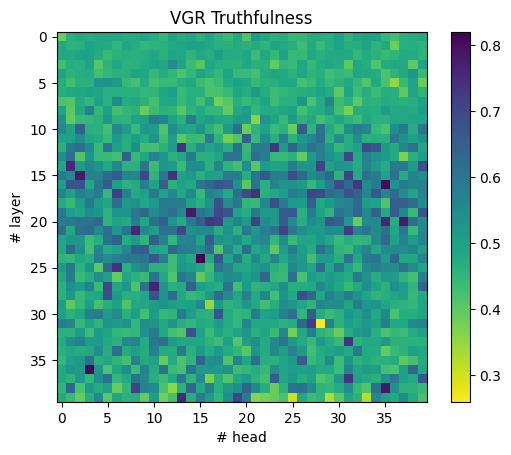

In [11]:
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 

llm_perf_sorted = np.copy(llm_perf)
llm_perf_sorted.sort(axis=1)
plt.imshow(llm_perf, cmap = reversed_map)
plt.title('VGR Truthfulness')

plt.xlabel('# head')
plt.ylabel('# layer')
plt.colorbar()
plt.show()